Hunter Bennett | Strains Project | June 16 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [11]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [12]:
# dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [13]:
if not os.path.isdir('./motif_enrichment_heatmaps/'):
    os.mkdir('./motif_enrichment_heatmaps/')

In [14]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_all.txt', sep='\t')

# Explore data a bit - this is a much easier way to compare results of known motif analysis

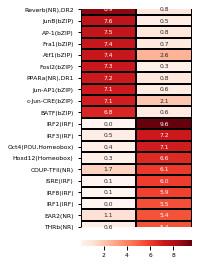

In [15]:
top_n = 10


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('trans')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(2,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})
    

In [16]:
df.columns

Index(['h3k27ac_trans_balb_hunterFCThenPadj_motifs', 'h3k27ac_trans_c57_hunterFCThenPadj_motifs'], dtype='object')

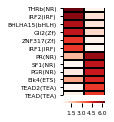

In [23]:
top_n = 6


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('mixed')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(0.75,2))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=False,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

plt.savefig('./figures/h3k27ac_mixed_distal_enrichment.pdf',
            bbox_inches='tight')

In [29]:
df.head()

,h3k27ac_mixed_balb_hunterFCThenPadj_motifs,h3k27ac_mixed_c57_hunterFCThenPadj_motifs
IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/Homer,-5.0800,-3.684
IRF3(IRF)/BMDM-Irf3-ChIP-Seq(GSE67343)/Homer,-1.0660,-1.188
ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer,-1.0290,-1.881
IRF1(IRF)/PBMC-IRF1-ChIP-Seq(GSE43036)/Homer,-3.5460,-1.498
MITF(bHLH)/MastCells-MITF-ChIP-Seq(GSE48085)/Homer,-0.2695,-1.695


In [30]:
np.log(0.05)

-2.995732273553991

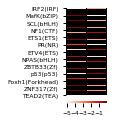

In [26]:
# top_n = 6


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('mixed')]
# only significant
tmp_df = df.loc[((df)<np.log(0.05)).any(1), :]

fig, ax = plt.subplots(figsize=(0.75,2))

# tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=False,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

plt.savefig('./figures/h3k27ac_mixed_distal_enrichment_sig_only.pdf',
            bbox_inches='tight')

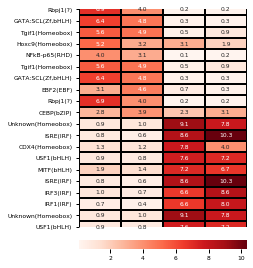

In [18]:
top_n = 5


# filter data
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, df.columns.str.contains('cis')]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

It seems like mixed motifs for balbcj correlate decently well with trans motifs for c57...

In [22]:
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df.columns

Index(['h3k27ac_cis_balb_hunterFCThenPadj_motifs',
       'h3k27ac_cis_c57_hunterFCThenPadj_motifs',
       'h3k27ac_mixed_balb_hunterFCThenPadj_motifs',
       'h3k27ac_mixed_c57_hunterFCThenPadj_motifs',
       'h3k27ac_trans_balb_hunterFCThenPadj_motifs',
       'h3k27ac_trans_c57_hunterFCThenPadj_motifs'],
      dtype='object')

In [35]:
df.columns

Index(['h3k27ac_trans_c57_hunterFCThenPadj_motifs',
       'h3k27ac_mixed_balb_hunterFCThenPadj_motifs',
       'h3k27ac_trans_c57_hunterFCThenPadj_motifs'],
      dtype='object')

In [41]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


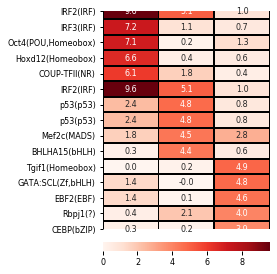

In [49]:
top_n = 5


# filter data
# df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
# df = df.loc[:, df.columns.str.contains('trans|mixed')]
df = known_motif_pval_frame.loc[:, ['h3k27ac_trans_c57_hunterFCThenPadj_motifs',
                                    'h3k27ac_mixed_balb_hunterFCThenPadj_motifs',
                                    'h3k27ac_cis_balb_hunterFCThenPadj_motifs']]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

d2 = dist.pdist(tmp_df.T)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

sns.heatmap(tmp_df.iloc[:, Z2['leaves']],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


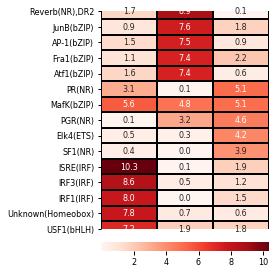

In [50]:
top_n = 5


# filter data
# df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
# df = df.loc[:, ~df.columns.str.contains('distal')]
# df = df.loc[:, df.columns.str.contains('trans|mixed')]
df = known_motif_pval_frame.loc[:, ['h3k27ac_trans_balb_hunterFCThenPadj_motifs',
                                    'h3k27ac_mixed_c57_hunterFCThenPadj_motifs',
                                    'h3k27ac_cis_c57_hunterFCThenPadj_motifs']]

# select top motifs
motifs = []
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    
fig, ax = plt.subplots(figsize=(3,5))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

d2 = dist.pdist(tmp_df.T)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

sns.heatmap(tmp_df.iloc[:, Z2['leaves']],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            # vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

Try and say something about motif correlation...

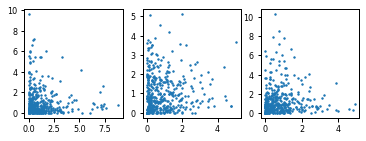

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(6,2))

axs[0].scatter(-known_motif_pval_frame.loc[:, 'h3k27ac_trans_balb_hunterFCThenPadj_motifs'],
               -known_motif_pval_frame.loc[:, 'h3k27ac_trans_c57_hunterFCThenPadj_motifs'],
               s=2)
axs[1].scatter(-known_motif_pval_frame.loc[:, 'h3k27ac_mixed_balb_hunterFCThenPadj_motifs'],
               -known_motif_pval_frame.loc[:, 'h3k27ac_mixed_c57_hunterFCThenPadj_motifs'],
               s=2)

axs[2].scatter(-known_motif_pval_frame.loc[:, 'h3k27ac_cis_balb_hunterFCThenPadj_motifs'],
               -known_motif_pval_frame.loc[:, 'h3k27ac_cis_c57_hunterFCThenPadj_motifs'],
               s=2)

In [64]:
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('hunterFCThenPadj')]
df = df.loc[:, ~df.columns.str.contains('distal')]
# df = df.loc[:, df.columns.str.contains('cis')]

In [71]:
(-df).corr(method='spearman').loc['h3k27ac_trans_balb_hunterFCThenPadj_motifs',
                 'h3k27ac_trans_c57_hunterFCThenPadj_motifs']

-0.08320725626489109

In [72]:
(-df).corr(method='spearman').loc['h3k27ac_mixed_balb_hunterFCThenPadj_motifs',
                 'h3k27ac_mixed_c57_hunterFCThenPadj_motifs']

0.043415944988695734

In [73]:
(-df).corr(method='spearman').loc['h3k27ac_cis_balb_hunterFCThenPadj_motifs',
                 'h3k27ac_cis_c57_hunterFCThenPadj_motifs']

0.13955558471983517